# A gentle introduction to performance

### PHYS 381

## Before we dive in...

[<img src="https://imgs.xkcd.com/comics/is_it_worth_the_time.png">](https://xkcd.com/1205/)

[<img src="https://imgs.xkcd.com/comics/automation.png">](https://xkcd.com/1319/)

[<img src="https://imgs.xkcd.com/comics/efficiency_2x.png">](https://xkcd.com/1445/)

## The code

We're going to look at performance of a shooting code, applied to the quantum harmonic oscillator.

In [2]:
import shooting as original

original.get_energies(original.harmonic, 5)

[0.500000003768,
 1.5000000022735187,
 2.5000000104073115,
 3.5000000051911777,
 4.500000001121005]

## First question

How long does it take to run?

### The simple way

In [3]:
import time
starting_time = time.time()
original.get_energies(original.harmonic, 5)
ending_time = time.time()
time_delta = ending_time - starting_time
time_delta

1.511915922164917

## The better way

In [4]:
%timeit original.get_energies(original.harmonic, 5)

1 loops, best of 3: 1.5 s per loop


In [5]:
%timeit original.get_energies(original.harmonic, 10)

1 loops, best of 3: 4.01 s per loop


In [6]:
%timeit original.get_energies(original.harmonic, 15)

1 loops, best of 3: 7.45 s per loop


In [7]:
%timeit original.get_energies(original.harmonic, 20)

1 loops, best of 3: 11.6 s per loop


In [8]:
# check overhead
%timeit original.get_energies(original.harmonic, 0)

100 loops, best of 3: 3.93 ms per loop


### Collecting this data...

In [9]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

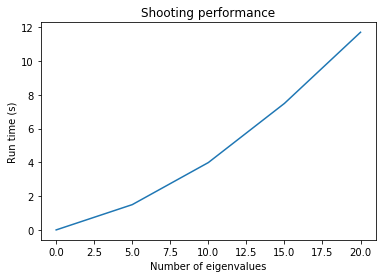

In [11]:
plt.plot([0,5,10,15,20], [3.95e-3, 1.5, 3.99, 7.49, 11.7], label="original")
plt.title("Shooting performance")
plt.ylabel("Run time (s)")
plt.xlabel("Number of eigenvalues");

## Second question:

What is it doing that takes as long as it does?

In [19]:
stats_5 = %prun -r original.get_energies(original.harmonic, 5)
stats_5.print_stats(6)

          561595 function calls in 1.708 seconds

   Ordered by: internal time
   List reduced from 33 to 6 due to restriction <6>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   185100    0.755    0.000    1.307    0.000 schrodinger.py:19(schro_rhs)
   185532    0.401    0.000    0.401    0.000 {built-in method numpy.core.multiarray.array}
      216    0.384    0.002    1.691    0.008 {built-in method scipy.integrate._odepack.odeint}
   185916    0.152    0.000    0.152    0.000 schrodinger.py:63(harmonic)
      216    0.007    0.000    0.012    0.000 function_base.py:25(linspace)
      216    0.002    0.000    0.002    0.000 {built-in method numpy.core.multiarray.arange}




In [20]:
stats_10 = %prun -r original.get_energies(original.harmonic, 10)
stats_10.print_stats(6)

          1504847 function calls in 4.576 seconds

   Ordered by: internal time
   List reduced from 33 to 6 due to restriction <6>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   497378    2.037    0.000    3.523    0.000 schrodinger.py:19(schro_rhs)
   498244    1.080    0.000    1.080    0.000 {built-in method numpy.core.multiarray.array}
      433    1.017    0.002    4.540    0.010 {built-in method scipy.integrate._odepack.odeint}
   499061    0.410    0.000    0.410    0.000 schrodinger.py:63(harmonic)
      433    0.015    0.000    0.023    0.000 function_base.py:25(linspace)
      866    0.003    0.000    0.004    0.000 copy.py:67(copy)




### Modification 1: trim some fat

In [25]:
# %load shooting/schrodinger.py


def get_energies(V, n=3, soft_edge=True):
    """Use shoot_for_eigenvalues to find energies.

    """
    from shooting import turning_point, shoot_for_eigenvalues
    
    args = (V,)
    ic = (0,1)
    if soft_edge:
        get_interval_endpoint = lambda x, y: turning_point(x, y, increment=5)
    else: # e.g., infinite square well
        get_interval_endpoint = turning_point
    energies = shoot_for_eigenvalues(schro_rhs, args, ic, get_interval_endpoint, n)
    return energies

def schro_rhs(y, x, E, V, m=1.0, hbar=1.0):
    """RHS for the time independent schrodinger equation.
    
    Parameters:
    -----------
    y : iterable of floats
        contains $\psi(x)$ and $\psi'(x)$
    x : float
        the position at which we're evaluating the equation
    E : float
        Energy of the quantum state
    V : function
        function for the potential
    m : float, optional
        mass; defaults to 1
    hbar : float, optional
           Planck's constant/2pi; defaults to 1
    
    Returns:
    --------
    float : the right hand side of the time independent schrodinger
            equation for the time independent Schrodinger equation:
            $$\frac{d^2\psi}{dx^2} = -\frac{2m}{\hbar^2}
            \left(E - V(x) \right)\psi.$$
    """
    psi, psiprime = y
    psidoubleprime = -(2*m/hbar**2)*(E-V(x))*psi
    
    return psiprime, psidoubleprime

In [26]:
%timeit get_energies(original.harmonic, 5)

1 loops, best of 3: 1.29 s per loop


In [27]:
%timeit get_energies(original.harmonic, 10)

1 loops, best of 3: 3.51 s per loop


In [30]:
neigs = range(0,26,5)
original_times = []
refactored_times = []
for n in neigs:
    time = %timeit -o original.get_energies(original.harmonic, n)
    original_times.append(time)
    newtime = %timeit -o get_energies(original.harmonic, n)
    refactored_times.append(newtime)

100 loops, best of 3: 3.85 ms per loop
100 loops, best of 3: 3.46 ms per loop
1 loops, best of 3: 1.52 s per loop
1 loops, best of 3: 1.32 s per loop
1 loops, best of 3: 4.05 s per loop
1 loops, best of 3: 3.51 s per loop
1 loops, best of 3: 7.45 s per loop
1 loops, best of 3: 6.5 s per loop
1 loops, best of 3: 11.6 s per loop
1 loops, best of 3: 10.2 s per loop
1 loops, best of 3: 16.9 s per loop
1 loops, best of 3: 14.7 s per loop


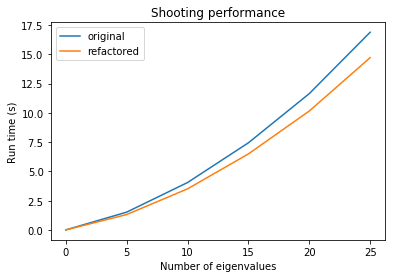

In [35]:
plt.plot(neigs, [res.best for res in original_times], label="original")
plt.plot(neigs, [res.best for res in refactored_times], label="refactored")
plt.title("Shooting performance")
plt.ylabel("Run time (s)")
plt.legend()
plt.xlabel("Number of eigenvalues");